### Set up API key

In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

# Load data from HF into Llamaindex

In [2]:
#Load from hub
from datasets import load_dataset
ds_hf = load_dataset("jealk/dk_retrieval_benchmark", "retsinformation", split="train")

In [16]:
print(f'There is a total of {len(ds_hf)} vejledninger in the dataset, the first one is: {ds_hf["vejledning"][0]}, that contains {len(ds_hf["indhold"][0])} characters')

There is a total of 431 vejledninger in the dataset, the first one is: Vejledning om beskæftigelseskravet for ret til barselsdagpenge, that contains 40497 characters


### Load into Llamaindex documents
Esentially just dicts with text and metadata

In [23]:
from llama_index import Document

#Iterate over the huggingface dataset object and create a list of llama documents
documents_vejledninger = [
    Document(text=content, metadata={"file_name": name})
    for name, content in zip(ds_hf["vejledning"], ds_hf["indhold"])
]

len(documents_vejledninger)

/home/jealk/mambaforge/envs/llm/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.14) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


431

In [6]:
documents_vejledninger[0].metadata

{'file_name': 'Vejledning om beskæftigelseskravet for ret til barselsdagpenge'}

In [7]:
documents_vejledninger[0].text[0:500]

'Vejledning om beskæftigelseskravet for ret til barselsdagpenge\n\n1.Indledning\nI denne vejledning beskrives hvilke beskæftigelseskrav, der gælder for at opnå ret til barselsdagpenge. Reglerne findes i §§ 27-29 i barselsloven (loven).\n\nI bekendtgørelse nr. 1090 af 1. juni 2021 om opgørelse af beskæftigelseskrav og beregning af barselsdagpenge m.v. (bekendtgørelsen) er fastsat nærmere regler om opgørelsen af beskæftigelseskravet.\n\nDenne vejledning erstatter vejledning nr. 10066 af 29. december 2020 '

## Chunking text
First parsing the data into nodes (llamaindex way of structuring data, including the relation to other nodes, embedding info etc.)

In [8]:
from llama_index.node_parser import SentenceSplitter
from transformers import AutoTokenizer

# Setting max length and defining tokenizer as intended embedding model (e5)
# Splitting preferably by \n (because I formated the html so that all <p> was replaced by a \n), and if no \n is found, split by nearest delimeter char . ? ! etc.
node_parser = SentenceSplitter(
    chunk_size=512,
    chunk_overlap=0,
    paragraph_separator="\n",
    tokenizer=AutoTokenizer.from_pretrained("intfloat/e5-base-v2").tokenize,
)


nodes_vejledninger = node_parser.get_nodes_from_documents(
    documents_vejledninger, show_progress=True
)

Parsing nodes:   0%|          | 0/431 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (16295 > 512). Running this sequence through the model will result in indexing errors


In [9]:
nodes_vejledninger[25].text

'Det blev indført i forbindelse med førtids- og pensionsreformen i 2013 for at sikre, at omlægningen af fleksjobordningen, hvorefter den ansatte i fleksjob alene modtager løn for de faktiske udførte arbejdstimer, ikke vil afskære personer i de nye fleksjob for at opfylde betingelserne for ret til dagpenge efter barselsloven. Derved blev sikret, at personer, der er ansat i et fleksjob efter § 120 i lov om en aktiv beskæftigelsesindsats, hvor ansættelsen er under 9,15 timer om ugen, har ret til dagpenge efter barselsloven.\n\nBemærk at en person, der er ansat i fleksjob efter den gamle fleksjobordning, skal opfylde beskæftigelseskravet for lønmodtagere i lovens § 27, stk. 1, nr. 1, for at opnå ret til dagpenge efter barselsloven.\n\n3.1.Opfyldelse af beskæftigelseskravet for selvstændig virksomhed, jf. lovens § 28, stk. 1'

### (Optional chunk len vizualization)
Inspecting the distribution of token size of the chunked data

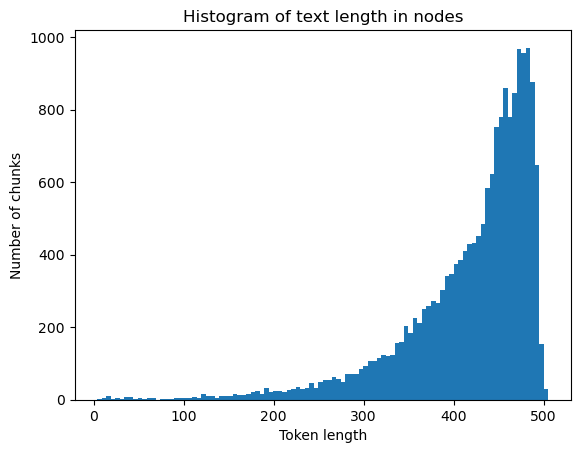

In [20]:
### Use HF tokenizer to verify length
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-base-v2")
token_counts = []
for text in [node.text for node in nodes_vejledninger]:
    token_counts.append(len(tokenizer.tokenize(text)))

# Efficient batch processing to tokenize all texts
# batch_dict = tokenizer([node.text for node in nodes_vejledninger], max_length=512, padding=True, truncation=True, return_tensors='pt')

# Plot a histogram of the length of the text in all nodes
import matplotlib.pyplot as plt

text_len = token_counts
plt.hist(text_len, bins=100)
plt.title("Histogram of text length in nodes")
plt.xlabel("Token length")
plt.ylabel("Number of chunks")
plt.show()

In [21]:
# Print first 5 examples of texts under 100 tokens
for i in range(5):
    print(f"Example {i+1} of texts under 100 tokens:")
    print(
        [
            node.text
            for node in nodes_vejledninger
            if len(tokenizer.tokenize(node.text)) < 100
        ][i]
    )
    print("\n")

Example 1 of texts under 100 tokens:
At-meddelelse 2.01.2 om gaffeltruckførercertifikat ophæves den 31. december 2017.

Arbejdstilsynet, den 22. november 2017


Example 2 of texts under 100 tokens:
5)Se De Laat-dommen, C-444/98.
6)Jf. cirkulæreskrivelse nr. 9569 af 22. november 2012.


Example 3 of texts under 100 tokens:
Andet sundhedspersonale dækker også personer, som udfører opgaver, der ikke hviler på en autorisation, men hvis virke har samme formål som de nævnte sundhedspersoner. Dette gælder f.eks. psykoterapeuter.


Example 4 of texts under 100 tokens:
Arbejdsskadestyrelsen, den 31. december  

 2000
Anne Lind Madsen
/Bent Mathiesen


Example 5 of texts under 100 tokens:
Arbejdstilsynets bekendtgørelse om indretning af tekniske hjælpemidler.

Arbejdstilsynet, den 27. juni 2019




**Short texts, what's happening?**

I inspected a few samples of the <100 token texts, and they all seem simply to be the end of documents, where this part likely could not fit into the context window of the previous chunk.

2 examples below,

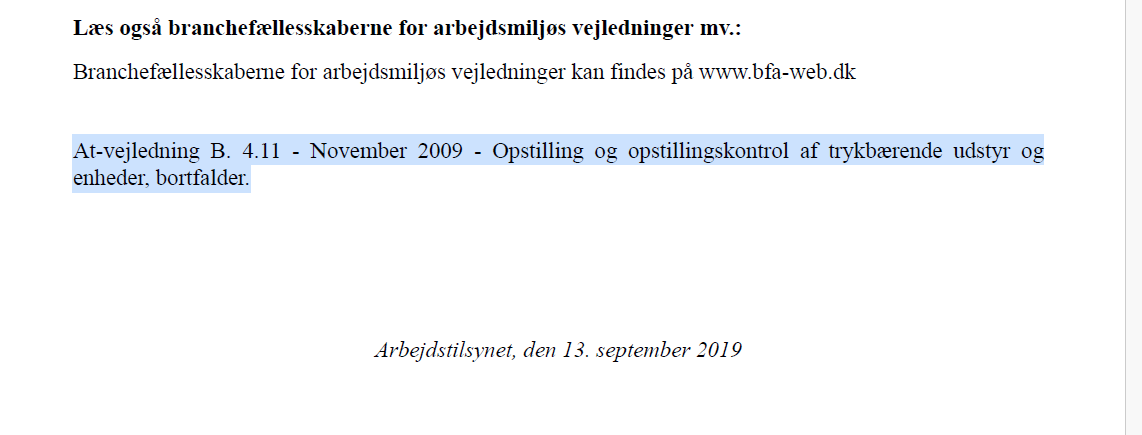


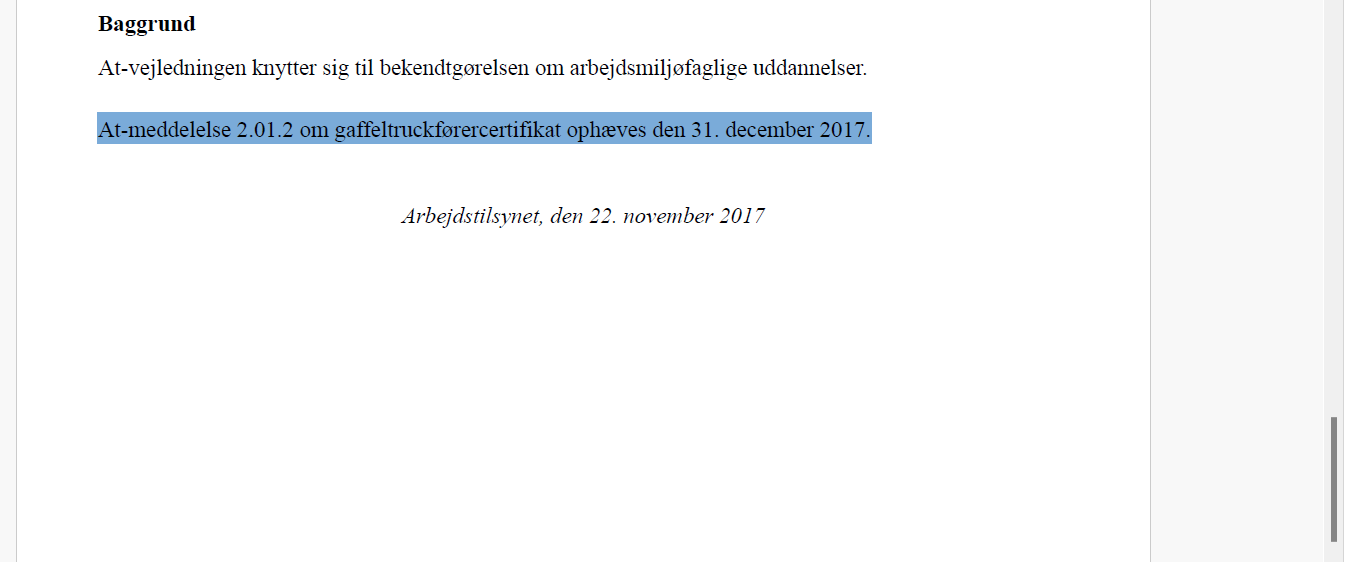

### Discarding short chunks
Discard any chunks less than 150 tokens long

In [12]:
### Use HF tokenizer to verify length
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-base-v2")

nodes_vejledninger_filtered = [
    node for node in nodes_vejledninger if len(tokenizer.tokenize(node.text)) > 150
]

In [13]:
nodes_vejledninger_filtered[0].text

'Vejledning om beskæftigelseskravet for ret til barselsdagpenge\n\n1.Indledning\nI denne vejledning beskrives hvilke beskæftigelseskrav, der gælder for at opnå ret til barselsdagpenge. Reglerne findes i §§ 27-29 i barselsloven (loven).\n\nI bekendtgørelse nr. 1090 af 1. juni 2021 om opgørelse af beskæftigelseskrav og beregning af barselsdagpenge m.v. (bekendtgørelsen) er fastsat nærmere regler om opgørelsen af beskæftigelseskravet.\n\nDenne vejledning erstatter vejledning nr. 10066 af 29. december 2020 om beskæftigelseskravet for ret til barselsdagpenge.\n\nEn lønmodtager har ret til barselsdagpenge, hvis pågældende opfylder ét af de fem krav om tilknytning til arbejdsmarkedet, der er nævnt i lovens § 27, stk. 1.\n\nKravet om aktuel beskæftigelse dagen før fraværet eller på første fraværsdag samt beskæftigelse i mindst 160 timer indberettet i indkomstregistret inden for de seneste 4 afsluttede kalendermåneder forud for fraværsperioden, jf. lovens § 27, stk. 1, nr. 1, er beskrevet i pkt

In [14]:
print(
    f"We now have {len(nodes_vejledninger_filtered)} chunks of text to generate questions from"
)

We now have 17868 chunks of text to generate questions from


#### Export nodes into a document store and saver for later use
The node object contains relevant info such as what node preceeded and followed it, and the meta data of the source document, both which might be relevant later. 


In [11]:
nodes_vejledninger_filtered[0]

NameError: name 'nodes_vejledninger_filtered' is not defined

In [35]:
from llama_index.storage.docstore import SimpleDocumentStore

# create (or load) docstore and add nodes
docstore = SimpleDocumentStore()
docstore.add_documents(nodes_vejledninger_filtered)

# persist nodes to disk
docstore.persist("data/node_store_25-11-23")

**Short addition to save parts of the node data in a dataframe for HF dataset creation**

In [37]:
from llama_index.storage.docstore import SimpleDocumentStore

# Load the SimpleDocumentStore from the persisted file
docstore = SimpleDocumentStore.from_persist_path("data/node_store_25-11-23")
# Create a list of nodes by list comprehension by iterating over the key (store hash) value (llamnaindex node) pairs of the docstore.docs object and appending the value to the list
nodes_vejledninger_filtered = [node for key, node in docstore.docs.items()]

In [39]:
#Create a pandas dataframe from the nodes_vejledninger_filtered object
#Only include the id_, metadata['file_name'] and text attributes of the object
import pandas as pd
df = pd.DataFrame([[node.metadata['file_name'], node.id_, node.text] for node in nodes_vejledninger_filtered], columns=['vejledning', 'chunk_id', 'chunk_text'])
df.head()

vejledning  \
0  Vejledning om beskæftigelseskravet for ret til...   
1  Vejledning om beskæftigelseskravet for ret til...   
2  Vejledning om beskæftigelseskravet for ret til...   
3  Vejledning om beskæftigelseskravet for ret til...   
4  Vejledning om beskæftigelseskravet for ret til...   

                               chunk_id  \
0  9281784d-734c-4665-b5dd-f6da8fd81859   
1  bbeb5fdc-a88b-4981-861c-65d14ff2d3ec   
2  3011dcf7-0ef2-43cb-9668-880ed01a5de5   
3  0ecf96e1-1982-472d-be10-df29d162aafb   
4  4c7f436c-b9b4-49eb-8766-8b111311eef3   

                                          chunk_text  
0  Vejledning om beskæftigelseskravet for ret til...  
1  Kravet om at ville have været berettiget til a...  
2  Det fremgår af lovens § 27, stk. 1, nr. 1, at ...  
3  Opgørelsen af beskæftigelseskravet sker som ud...  
4  Hvis det i forbindelse med Udbetaling Danmarks...

In [40]:
#Save the dataframe as a csv file ensure that non ascii characters are encoded as utf-8
df.to_csv('data/chunks_id_text-3-12-23-v2.csv', encoding='utf-8')

## Generate Q 

**Write the Question gen prompt template**

In [15]:
from llama_index.prompts import PromptTemplate

# Define your custom prompt template in Danish
qa_sagsbehandler_tmlp = """ Nedenfor er et uddrag (kontekst) fra en længere tekst:
---------------------
{context_str}
---------------------
Givet ovenstående uddrag (kontekst) og ingen forudgående viden, er din opgave at generere spørgsmål til teksten.
Du er en erfaren sagsbehandler, og din opgave er at stille præcis {num_questions_per_chunk} spørgsmål, som kan besvares i uddraget.
Spørgsmålene skal være af forskellig karakter og dække teksten bredt, men stilles i et sprog som en borger uden juridisk ekspertise kan forstå.
Svaret til spørgsmålet, skal kunne findes i ovenstående uddrag (kontekst).
"""

qa_sagsbehandler_tmlp = PromptTemplate(qa_sagsbehandler_tmlp)

**Generate the questions**

In [17]:
from llama_index.finetuning import generate_qa_embedding_pairs
from llama_index.llms import OpenAI

# define LLM
llm_oai = OpenAI(temperature=0.0, model="gpt-4-1106-preview")

qa_dataset = generate_qa_embedding_pairs(
    qa_generate_prompt_tmpl=qa_sagsbehandler_tmlp,
    llm=llm_oai,
    nodes=nodes_vejledninger_filtered[0:100],
    num_questions_per_chunk=2,
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [14:01<00:00,  8.41s/it]


**Example of generated questions**

In [19]:
for query_id, query in qa_dataset.queries.items():
    node_id = qa_dataset.relevant_docs[query_id][0]
    text = qa_dataset.corpus[node_id]
    print(f"Spørgsmål:\n {query} \n")
    print(f"Chunk:\n {text} \n")
    break

Spørgsmål:
 Hvilke dokumenter skal jeg kigge i for at forstå de detaljerede regler om, hvordan man opgør arbejdstimer for at være berettiget til barselsdagpenge? 

Chunk:
 Vejledning om beskæftigelseskravet for ret til barselsdagpenge

1.Indledning
I denne vejledning beskrives hvilke beskæftigelseskrav, der gælder for at opnå ret til barselsdagpenge. Reglerne findes i §§ 27-29 i barselsloven (loven).

I bekendtgørelse nr. 1090 af 1. juni 2021 om opgørelse af beskæftigelseskrav og beregning af barselsdagpenge m.v. (bekendtgørelsen) er fastsat nærmere regler om opgørelsen af beskæftigelseskravet.

Denne vejledning erstatter vejledning nr. 10066 af 29. december 2020 om beskæftigelseskravet for ret til barselsdagpenge.

En lønmodtager har ret til barselsdagpenge, hvis pågældende opfylder ét af de fem krav om tilknytning til arbejdsmarkedet, der er nævnt i lovens § 27, stk. 1.

Kravet om aktuel beskæftigelse dagen før fraværet eller på første fraværsdag samt beskæftigelse i mindst 160 timer

**Save / Load Q&A dataset**

In [18]:
# Save qa_dataset as json
qa_dataset.save_json("data/qa_dataset_gp41106_07-12-23_100_samples.json")